In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fitsio

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table


# Set some plotting environment variables
sns.set(style='white', context='paper', palette='Set1')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

In [3]:
fuji = Table(fitsio.read('fuji-matches.fits')) # table of all matches

# Let's explore the matches

In [4]:
# histogram various values

def fujiHist(key, table=fuji, **kwargs):
    '''
    key [str] : key that exists in the astropy Table
    table [astropy Table] : to plot from
    '''
    
    fig, ax = plt.subplots(1,1)
    
    ax.hist(table[key], color='cornflowerblue', **kwargs)
    ax.set_ylabel('N')
    ax.set_xlabel(key.lower().strip('_'))

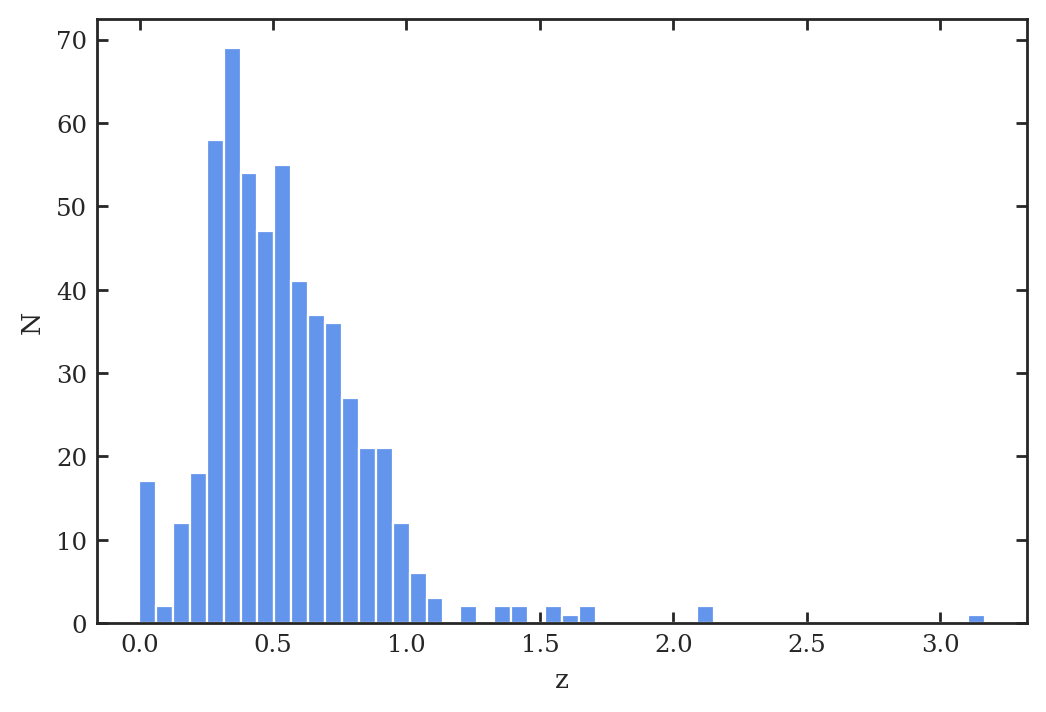

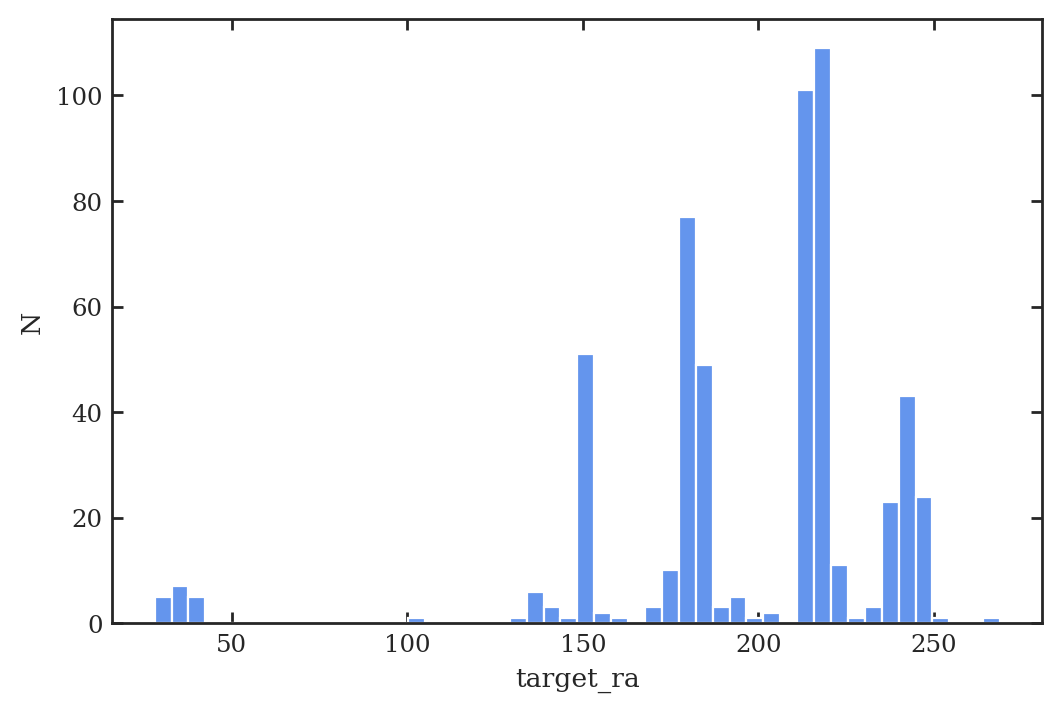

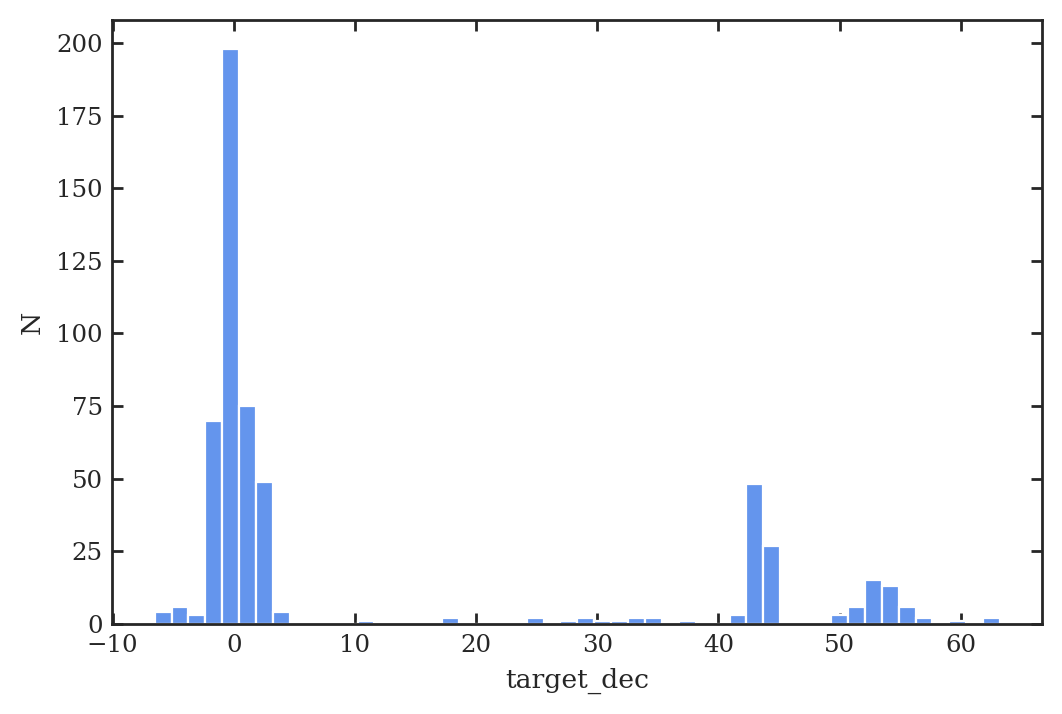

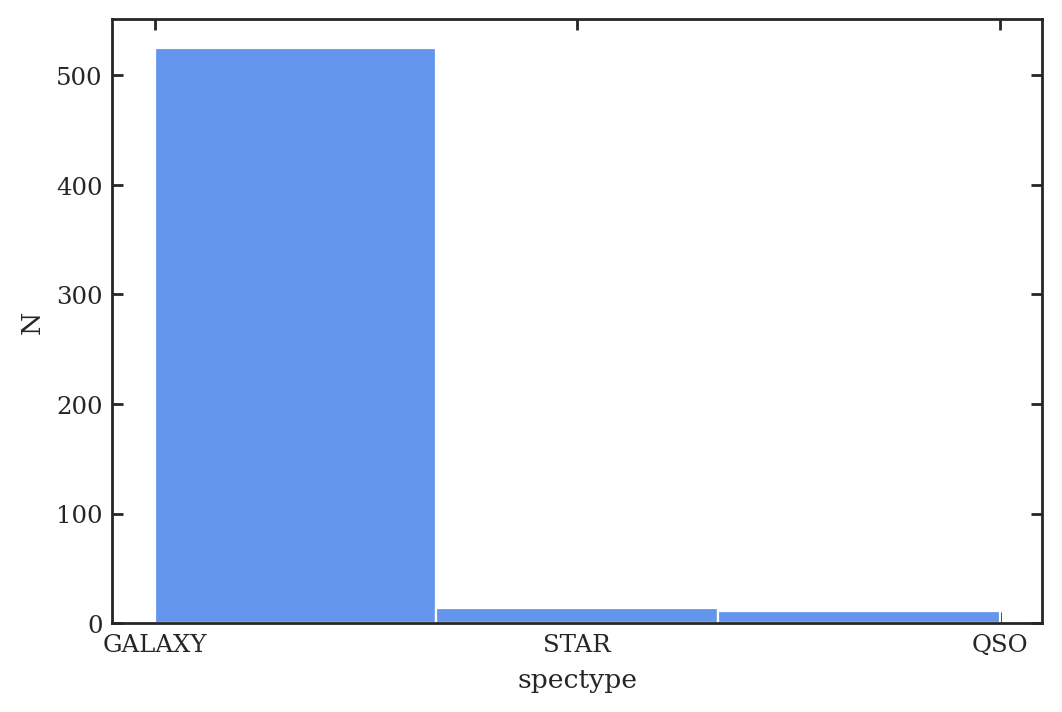

In [5]:
fujiHist('Z', bins=50)
fujiHist('TARGET_RA', bins=50)
fujiHist('TARGET_DEC', bins=50)
fujiHist('SPECTYPE', bins=3)

# Plot Skymap

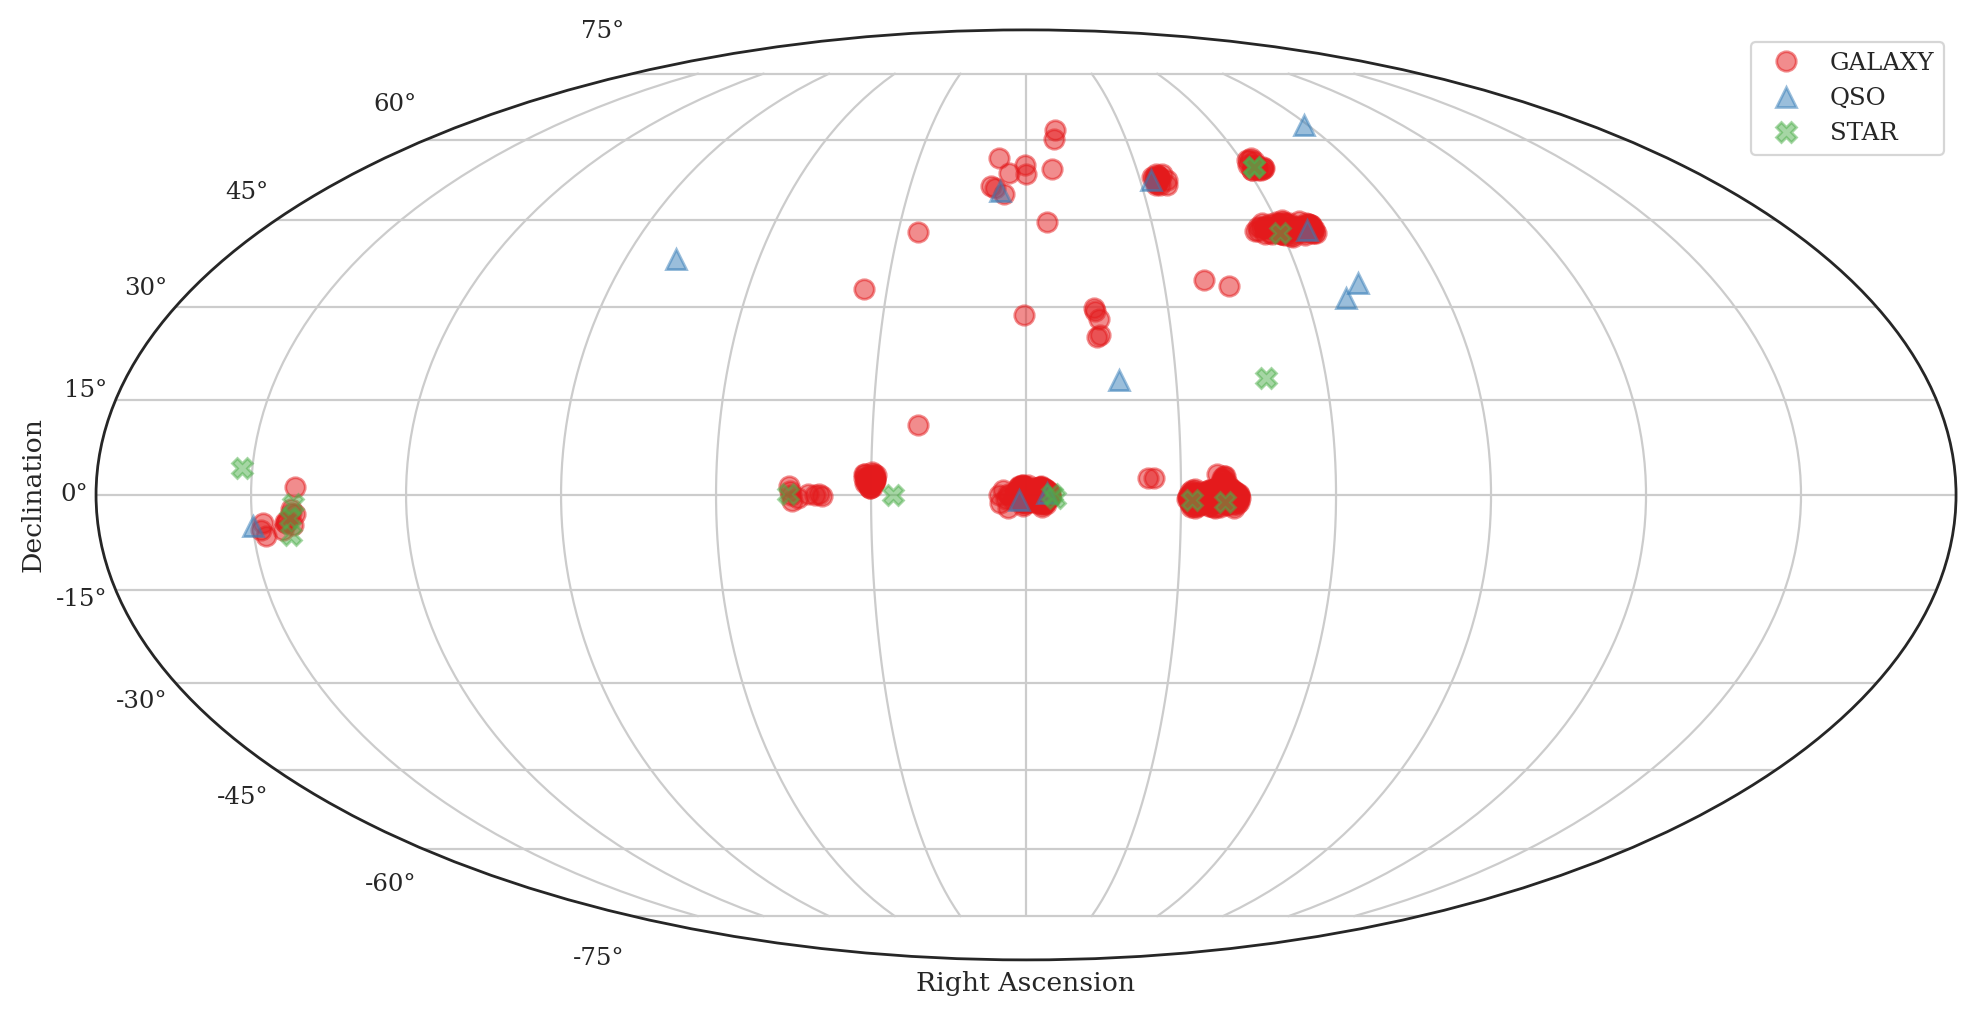

In [6]:
a = 0.5
ms = 7
key = 'SPECTYPE'#'SURVEY'

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection="mollweide")

shapes = ['o', '^', 'X', 'x', '<', '>', 'v']

for val, s in zip(np.unique(fuji[key]), shapes):

    ff = fuji[fuji[key] == val]
    
    targRA = coord.Angle((ff['TARGET_RA']+180)*u.deg)
    targDec = coord.Angle(ff['TARGET_DEC']*u.deg)

    targRA = targRA.wrap_at(180*u.deg)

    ax.plot(targRA.radian, targDec.radian, s, label=val, zorder=2, markersize=ms, alpha=a)

ax.grid()
ax.set_xticklabels([])
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
_=ax.legend(loc='upper right')
fig.savefig('mollweide-projection-matches.png', bbox_inches='tight', transparent=False)

In [14]:
fuji.keys()

['TARGETID',
 'SURVEY',
 'PROGRAM',
 'HEALPIX',
 'SPGRPVAL',
 'Z',
 'ZERR',
 'ZWARN',
 'CHI2',
 'COEFF',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'COADD_FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'RELEASE',
 'BRICKNAME',
 'BRICKID',
 'BRICK_OBJID',
 'MORPHTYPE',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'PHOTSYS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'CMX_TARGET',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET',
 'SCND_TARGET',
 'SV1_DESI_TARGET',
 'SV1_BGS_TARGET',
 'SV1_MWS_TARGET',
 